In [7]:
import zipfile as zf
files = zf.ZipFile("/content/data-20230802T125457Z-001.zip", 'r')
files.extractall('olive_data')
files.close()

In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
import os

In [14]:
# Input folder containing images
input_folder = '/content/olive_data/data'

In [15]:
import os
# Output folder for cut-out objects
output_folder = '/content/cutout_objects'
os.makedirs(output_folder, exist_ok=True)

In [16]:
# Define the color range for object detection
lower_bound = np.array([0, 0, 0])
upper_bound = np.array([100, 100, 100])

In [17]:
for filename in os.listdir(input_folder):
    if filename.endswith('.JPG'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Create a mask for the object you want to cut out
        mask = cv2.inRange(image, lower_bound, upper_bound)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour (assumed to be the object you want to cut out)
            largest_contour = max(contours, key=cv2.contourArea)

            # Create an empty mask for the object
            object_mask = np.zeros_like(mask)

            # Draw the largest contour on the object mask
            cv2.drawContours(object_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Bitwise AND the object mask with the original image to get the cut-out object
            cutout = cv2.bitwise_and(image, image, mask=object_mask)

            # Create a white background image of the same size as the original image
            white_background = np.ones_like(image) * 255

            # Invert the object mask to get the background mask
            background_mask = cv2.bitwise_not(object_mask)

            # Combine the cutout object with the white background using the masks
            replaced_background = cv2.bitwise_and(white_background, white_background, mask=background_mask)
            replaced_background += cutout

            # Save the image with the replaced white background
            replaced_filename = f'replaced_{filename}'
            replaced_path = os.path.join(output_folder, replaced_filename)
            cv2.imwrite(replaced_path, replaced_background)

In [18]:
# Load the segmented image
segmented_image = cv2.imread("/content/cutout_objects/replaced_DJI_0335.JPG")

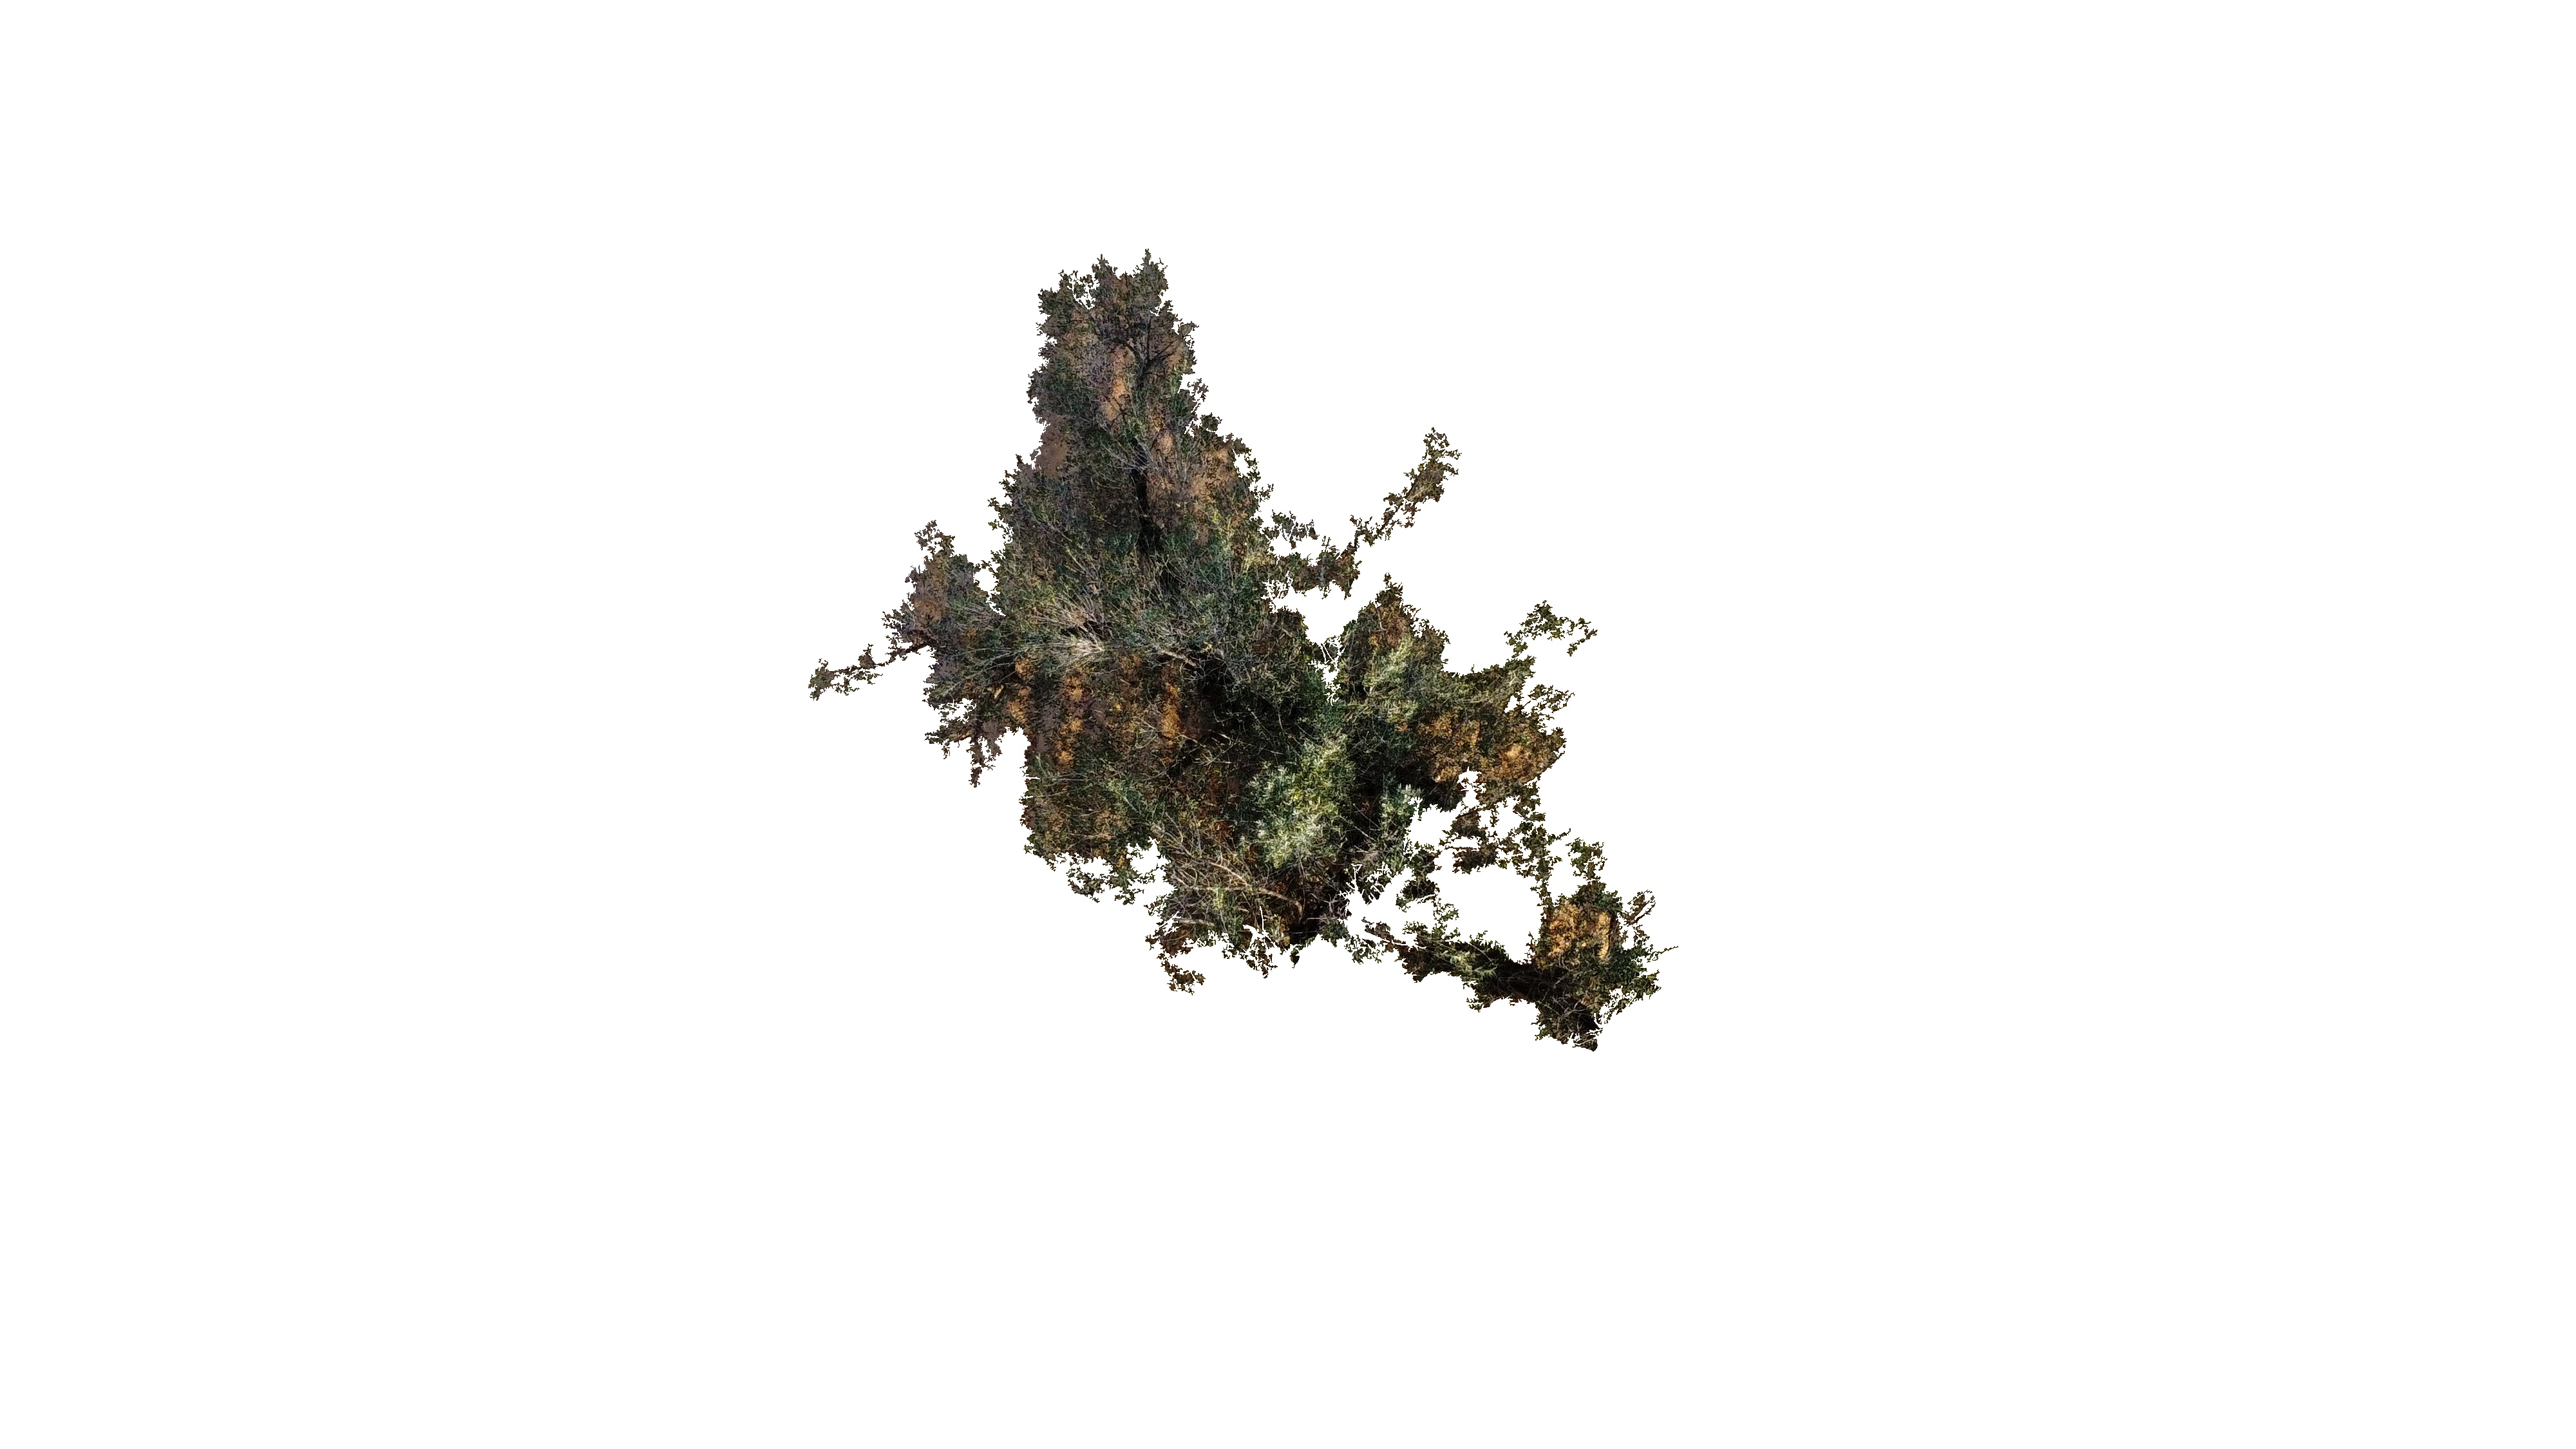

In [19]:
# Display the segmented image
cv2_imshow(segmented_image)

In [20]:
def calculate_soil_percentage(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 50, 50])  # Lower bound of soil color in HSV
    upper_bound = np.array([30, 255, 255])

    total_pixels = image.shape[0] * image.shape[1]

    # total_non_black_pixels = total_pixels - black_pixels

    # Define a mask using the specified color range for soil
    soil_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Calculate the percentage of soil pixels

    soil_pixels = cv2.countNonZero(soil_mask)
    soil_percentage = (soil_pixels / total_pixels )

    return soil_mask, soil_percentage

In [21]:
def calculate_green_percentage(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    green_pixels = np.count_nonzero((hsv_image>= 50) & (hsv_image <= 100))

    total_pixels = image.shape[0] * image.shape[1]

    # total_non_black_pixels = total_pixels - black_pixels

    # green_pixels = cv2.countNonZero(green_mask)
    green_percentage = (green_pixels / total_pixels)

    return green_percentage

In [22]:
# Load the segmented image
segmented_image_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

In [23]:
# Define the square size
square_size = 100

In [24]:
# Initialize variables for total and count
total_sol_percentage = 0
total_feuil_percentage = 0
square_count = 0

In [25]:

image_folder = "/content/cutout_objects"  # Replace with the path to your image folder
csv_file_path = "data_olive.csv"

total_sol_percentage = 0
total_feuil_percentage = 0
total_black_percentage = 0
total_lai_percentage = 0
square_count = 0
data= []
#
for filename in os.listdir(image_folder):
        if filename.endswith(".JPG"):  # Adjust the file extension as needed
            image_path = os.path.join(image_folder, filename)

            soil_mask,soil_percentage = calculate_soil_percentage(image_path)
            # black_percentage = calculate_black_percentage(image_path)
            green_percentage = calculate_green_percentage(image_path)

            lai = -2 * math.log(1 - soil_percentage)  # LAI = -2 * ln(1 - Soil%)


            # Load the image
            image = cv2.imread(image_path)
            segmented_image = image.copy()
            segmented_image_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

            # Create a copy of the segmented_image for visualization
            visualized_image = segmented_image.copy()



            # Iterate over the image in steps of square_size
            for y in range(0, segmented_image.shape[0], square_size):
                for x in range(0, segmented_image.shape[1], square_size):
                    square = segmented_image_gray[y:y+square_size, x:x+square_size]

                    # Calculate feuil (percentage of green pixels in the square)
                    green_pixels = np.count_nonzero((square >= 50) & (square <= 100))  # Example green range


                    black_pixels = np.count_nonzero((square == 0 ))

                    soil_pixels = np.count_nonzero((square >= 70) & (square <= 120))  # Example green range
                    # soil_pixels = np.count_nonzero((square > 100) & (square <= 120))
                    # soil_pixels = np.count_nonzero(np.all((square >= soil_lower_bound) & (square <= soil_upper_bound), axis=2))
                    black_percentage = (black_pixels / (square_size * square_size))

                    sol_percentage = (soil_pixels / (square_size * square_size))   # SOL calculation
                    lai_percentage = -2 * math.log(1-sol_percentage)  # Feuil calculation
                    feuil_percentage = (green_pixels / (square_size * square_size))

                    if green_pixels > 0:  # Only calculate sol if there are green pixels in the square
                    # sol_percentage = np.exp(-0.5 * feuil_percentage)

                    # Accumulate values for total and count
                      total_sol_percentage += sol_percentage
                      total_lai_percentage += lai_percentage
                      total_feuil_percentage += feuil_percentage
                      total_black_percentage += black_percentage
                      square_count += 1

                      # Draw rectangle around the square on the visualized image
                      top_left = (x, y)
                      bottom_right = (x + square_size, y + square_size)
                      color = (0, 255, 0)  # Green color for rectangles
                      thickness = 2  # Thickness of the rectangle
                      cv2.rectangle(visualized_image, top_left, bottom_right, color, thickness)

                      # Display sol and feuil values on the visualized image
                      text = f"sol: {sol_percentage:.2f}%\nfeuil: {feuil_percentage:.2f}%"
                      text_position = (x, y + square_size + 15)
                      font = cv2.FONT_HERSHEY_SIMPLEX
                      font_scale = 0.4
                      font_color = (255, 255, 255)  # White color for text
                      cv2.putText(visualized_image, text, text_position, font, font_scale, font_color, thickness=1)

            # Calculate the averages
            average_sol_percentage = total_sol_percentage / square_count if square_count > 0 else 0
            average_feuil_percentage = total_feuil_percentage / square_count if square_count > 0 else 0
            average_black_percentage = total_black_percentage / square_count if square_count > 0 else 0
            average_lai_percentage = total_lai_percentage / square_count if square_count > 0 else 0

            # Print the totals and averages
            print(f"Image: {filename}")
            print("="*45)

            # print("image statistic")

            # print(f"Sol percentage in image: {soil_percentage*100:.2f}%")
            # print(f"LAI percentage in image: {lai*100:.2f}%")
            # print(f"feuil percentage in image: {green_percentage*100:.2f}%")
            # print(f"black percentage in image: {(1-(soil_percentage+lai+green_percentage)) *100:.2f}%")
            # print("="*45)
            # # print(f"Black percentage in image: {black_percentage*100:.2f}%")
            # print("image statistic using frames")

            # print(f"Average Soil percentage of frames: {average_sol_percentage*100:.2f}%")
            # print(f"Average LAI percentage of frames: {average_lai_percentage*100:.2f}%")
            # print(f"Average Feuil percentage of frames: {average_feuil_percentage*100:.2f}%")
            # print(f"Average Black percentage of frames: {average_black_percentage*100:.2f}%")
            # print(f"Accuracy equal : {100-(1-(average_black_percentage+average_feuil_percentage+average_sol_percentage)):.2f}%")

            # print(f"number of frame: {square_count:.2f}")

            # Sample data as a list of dictionaries
            ligne ={"image name": filename , "% sol": f"{soil_percentage*100:.2f}","% lai":f"{lai*100:.2f}","%feuil":f"{green_percentage*100:.2f}","% black":f"{(1-(soil_percentage+lai+green_percentage)) *100:.2f}","frame avg soil":f"{average_sol_percentage*100:.2f}","frame avg lai":f"{average_lai_percentage*100:.2f}","frame avg feuil":f"{average_feuil_percentage*100:.2f}","frame avg black":f"{average_black_percentage*100:.2f}"}
            data.append(ligne)


            # Display the visualized image
            # cv2_imshow(visualized_image)


            print("=" * 45)
            print("=" *45)


Image: replaced_DJI_0340.JPG
Image: replaced_DJI_0353.JPG
Image: replaced_DJI_0317.JPG
Image: replaced_DJI_0355.JPG
Image: replaced_DJI_0292.JPG
Image: replaced_DJI_0332.JPG
Image: replaced_DJI_0289.JPG
Image: replaced_DJI_0337.JPG
Image: replaced_DJI_0325.JPG
Image: replaced_DJI_0331.JPG
Image: replaced_DJI_0315.JPG
Image: replaced_DJI_0295.JPG
Image: replaced_DJI_0314.JPG
Image: replaced_DJI_0356.JPG
Image: replaced_DJI_0312.JPG
Image: replaced_DJI_0368.JPG
Image: replaced_DJI_0306.JPG
Image: replaced_DJI_0336.JPG
Image: replaced_DJI_0371.JPG
Image: replaced_DJI_0279.JPG
Image: replaced_DJI_0346.JPG
Image: replaced_DJI_0342.JPG
Image: replaced_DJI_0290.JPG
Image: replaced_DJI_0327.JPG
Image: replaced_DJI_0376.JPG
Image: replaced_DJI_0326.JPG
Image: replaced_DJI_0297.JPG
Image: replaced_DJI_0282.JPG
Image: replaced_DJI_0305.JPG
Image: replaced_DJI_0373.JPG
Image: replaced_DJI_0330.JPG
Image: replaced_DJI_0302.JPG
Image: replaced_DJI_0303.JPG
Image: replaced_DJI_0316.JPG
Image: replace

In [26]:
import csv
with open(csv_file_path, mode='w', newline='') as csv_file:
                fieldnames = data[0].keys()
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

                # Write the header row
                writer.writeheader()

                # Write the data rows
                for row in data:
                  writer.writerow(row)

print(f"Data has been written to {csv_file_path}")


Data has been written to data_olive.csv


In [31]:
import pandas as pd

In [32]:
data=pd.read_csv("/content/data_olive.csv")

In [34]:
data

,image name,% sol,% lai,%feuil,% black,frame avg soil,frame avg lai,frame avg feuil,frame avg black
0,replaced_DJI_0340.JPG,2.75,5.57,6.54,85.14,16.03,36.69,22.09,0.09
1,replaced_DJI_0353.JPG,1.72,3.47,5.08,89.74,21.12,53.70,27.85,0.06
2,replaced_DJI_0317.JPG,2.38,4.82,2.96,89.83,18.95,47.21,26.00,0.05
3,replaced_DJI_0355.JPG,2.40,4.86,6.23,86.52,22.48,58.27,28.78,0.03
4,replaced_DJI_0292.JPG,2.34,4.73,9.03,83.91,22.66,59.09,31.34,0.03
...,...,...,...,...,...,...,...,...,...
100,replaced_DJI_0344.JPG,3.50,7.13,6.40,82.97,18.88,46.95,30.77,0.04
101,replaced_DJI_0350.JPG,4.01,8.19,10.40,77.39,18.94,47.22,30.83,0.04
102,replaced_DJI_0293.JPG,2.13,4.30,4.65,88.92,18.94,47.20,30.84,0.04
103,replaced_DJI_0377.JPG,1.45,2.93,1.82,93.80,18.89,47.07,30.80,0.04


In [43]:
# Calculez la moyenne de la colonne "Colonne1"
moyenne_colonne1 = data["frame avg lai"].mean()
moyenne_colonne2 = data["frame avg feuil"].mean()
moyenne_colonne3 = data["frame avg soil"].mean()

# Affichez la moyenne
print(f"Moyenne de la colonne 'frame avg lai': {moyenne_colonne1:.2f}")
print(f"Moyenne de la colonne 'frame avg feuil': {moyenne_colonne2:.2f}")
print(f"Moyenne de la colonne 'frame avg sol': {moyenne_colonne3:.2f}")

Moyenne de la colonne 'frame avg lai': 48.01
Moyenne de la colonne 'frame avg feuil': 30.50
Moyenne de la colonne 'frame avg sol': 19.26


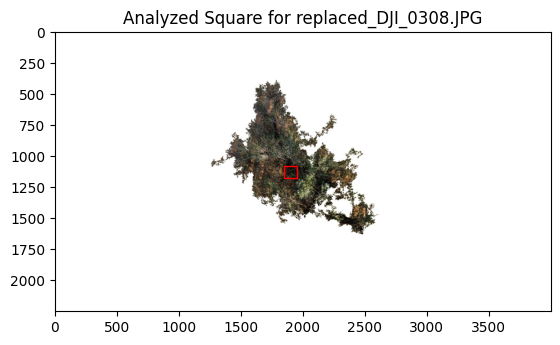

Image: replaced_DJI_0308.JPG
Soil percentage: 19.27%
Estimated LAI percentage: 42.81
green percentage: 36.17
BLACK percentage: 16.21


In [27]:

image_folder="/content/cutout_objects/replaced_DJI_0335.JPG"
# Load the image for the square-based calculations
image = cv2.imread(image_folder)
segmented_image = image.copy()
segmented_image_gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

square_size=100
# Create a copy of the segmented_image for visualization
visualized_image = segmented_image.copy()
#=====================================================================
# we work about small square ((fram)) for the visualisation
#=====================================================================

# Extract the central square for analysis
y_center = segmented_image.shape[0] // 2
x_center = segmented_image.shape[1] // 2
y_start = y_center - square_size // 2
x_start = x_center - square_size -100 // 2
square = segmented_image[y_start:y_start+square_size, x_start:x_start+square_size]

# green_pixels = np.count_nonzero((square >= 50) & (square <= 100))  # COLOR range

black_pixels = np.count_nonzero((square == 0 ))

soil_pixels = np.count_nonzero((square >= 70) & (square <= 120))  # COLOR range

black_percentage = (black_pixels / (square_size * square_size))

soil_percentage = (soil_pixels / (square_size * square_size))  # SOL calculation
lai = (-2) * math.log(1-soil_percentage)  # Feuil calculation
green_pixels = np.count_nonzero((square >= 50) & (square <= 100))
green = (green_pixels / (square_size * square_size))

# Display the image and draw a rectangle around the analyzed square
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
rect = plt.Rectangle((x_start, y_start), square_size, square_size, fill=False, color='red')
plt.gca().add_patch(rect)
plt.title(f"Analyzed Square for {filename}")
plt.show()
print(f"Image: {filename}")
print(f"Soil percentage: {soil_percentage*100:.2f}%")
print(f"Estimated LAI percentage: {lai*100:.2f}")
print(f"green percentage: {green*100:.2f}")
print(f"BLACK percentage: {black_percentage*100:.2f}")
print("=" * 40)